In [4]:
cat ./data/student.txt

# Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2 sex - student's sex (binary: "F" - female or "M" - male)
3 age - student's age (numeric: from 15 to 22)
4 address - student's home address type (binary: "U" - urban or "R" - rural)
5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from sklearn import cross_validation
from pandas.tools.plotting import scatter_matrix
from IPython.display import display

In [2]:
%matplotlib inline
student_mat = pd.read_csv("./data/student-mat.csv", sep = ";")
student_por = pd.read_csv("./data/student-por.csv", sep = ";")

Perform Kolmogorov-Smirnow to test whether portugese and math classes differ a lot in their alcohol consumption

In [3]:
display(stats.ks_2samp(student_mat['Walc'], student_por['Walc']))
display(stats.ks_2samp(student_mat['Dalc'], student_por['Dalc']))

Ks_2sampResult(statistic=0.014241969144350608, pvalue=0.99999999971045828)

Ks_2sampResult(statistic=0.0072516627333190087, pvalue=1.0000000000000002)

In [4]:
display(student_por.shape)
display(student_mat.shape)

(649, 33)

(395, 33)

Let's doo some preprocessing. Dalc and Walc together can represend alcohol consumption over the whole week. Reducing those features can improve our model since (highly likely) they are correlated 

In [5]:
# TODO: Dalc + Walc processing
def process_alc(data):
    result = data
    result['alc'] = data.apply(lambda row: ((row['Dalc'] * 5.0) + (row['Walc'] * 2.0)) / 7, axis = 1)
    result.drop(['Dalc', 'Walc'], inplace = True, axis = 1)
    return result

process_alc(student_mat)
process_alc(student_por)

student_mat.head(1)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,health,absences,G1,G2,G3,alc
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,3,6,5,6,6,1


Group students who attended both courses and average their features:

In [6]:
# Select students who attended both courses
# students = pd.merge(student_mat, student_por, suffixes = ["_mat", "_por"], on = ["school",
#                                                                                   "sex",
#                                                                                   "age",
#                                                                                   "address",
#                                                                                   "famsize",
#                                                                                   "Pstatus",
#                                                                                   "Medu",
#                                                                                   "Fedu",
#                                                                                   "Mjob",
#                                                                                   "Fjob",
#                                                                                   "reason",
#                                                                                   "nursery",
#                                                                                   "internet"])

students = pd.concat([student_mat, student_por]).groupby(["school",
                                                          "sex",
                                                          "age",
                                                          "address",
                                                          "famsize",
                                                          "Pstatus",
                                                          "Medu",
                                                          "Fedu",
                                                          "Mjob",
                                                          "Fjob",
                                                          "reason",
                                                          "nursery",
                                                          "internet"]).mean().reset_index()

# Let's average alcohol consumption for those students who attended both portugese ant math courses
# students['alc'] = students[['alc_mat', 'alc_por']].mean(axis = 1)
# students.drop(['alc_mat', 'alc_por'], axis = 1, inplace = True)
students.shape

(662, 25)

In [7]:
corr = students.corr().abs().stack()
corr = corr.mask(corr == 1).nlargest(30)
corr

G2          G3            0.929504
G3          G2            0.929504
G1          G2            0.864015
G2          G1            0.864015
G1          G3            0.833133
G3          G1            0.833133
Medu        Fedu          0.635156
Fedu        Medu          0.635156
failures    G3            0.399402
G3          failures      0.399402
failures    G2            0.388831
G2          failures      0.388831
failures    G1            0.374796
G1          failures      0.374796
age         failures      0.344902
failures    age           0.344902
freetime    goout         0.336630
goout       freetime      0.336630
            alc           0.335732
alc         goout         0.335732
Medu        G2            0.247008
G2          Medu          0.247008
Medu        G1            0.244235
G1          Medu          0.244235
Medu        traveltime    0.241882
traveltime  Medu          0.241882
studytime   G1            0.233655
G1          studytime     0.233655
Medu        G3      

/home/kernelmode/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


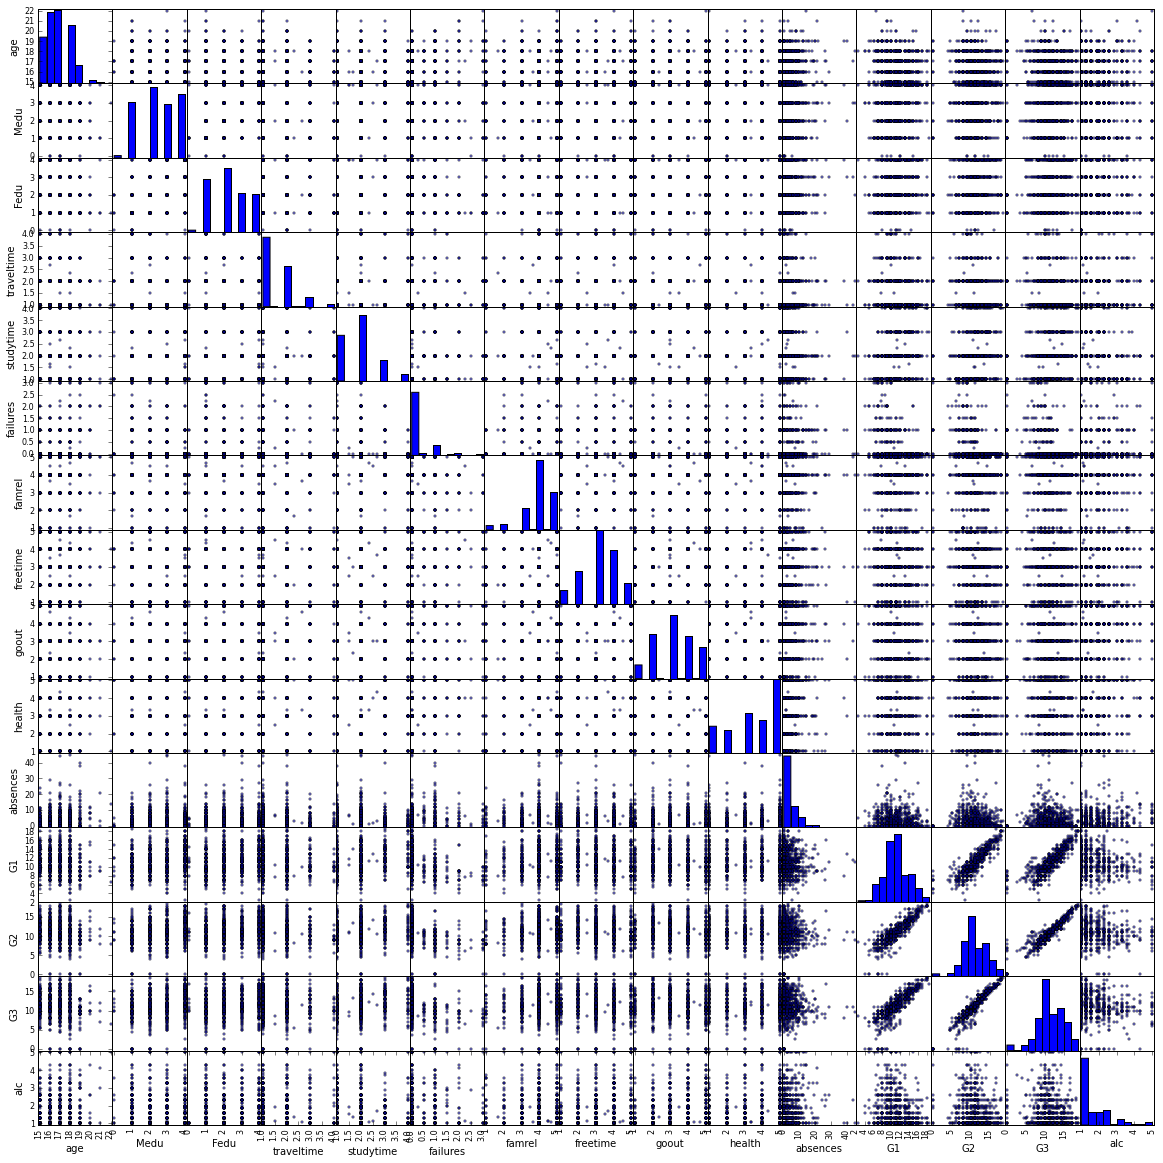

In [67]:
scatter_matrix(students, diagonal = 'hist', figsize=(20, 20));

In [8]:
students['high_consumption'] = students['alc'] > 3
students.drop('alc', axis = 1, inplace = True)

In [9]:
from sklearn import tree
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score

data = students.drop('high_consumption', axis = 1)
# data = pd.get_dummies(data, columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'vities', 'nursery', 'higher', 'internet', 'romantic'])
data = pd.get_dummies(data)
target = students['high_consumption']
# x_train, x_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)

clf = tree.DecisionTreeClassifier()
# clf = clf.fit(x_train, y_train)
# clf.score(x_test, y_test)
cross_val_score(clf, data, target).mean()

0.40043680043680041

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=5, max_depth=None, min_samples_split=1, random_state=0)
cross_val_score(rf_clf, data, target).mean()

0.83210483210483199

In [23]:
import xgboost as xgb

param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}
xgb.cv(param, data.as_matrix(), 2, nfold=5, metrics={'error'}, seed = 0)

AttributeError: 'numpy.ndarray' object has no attribute 'num_row'

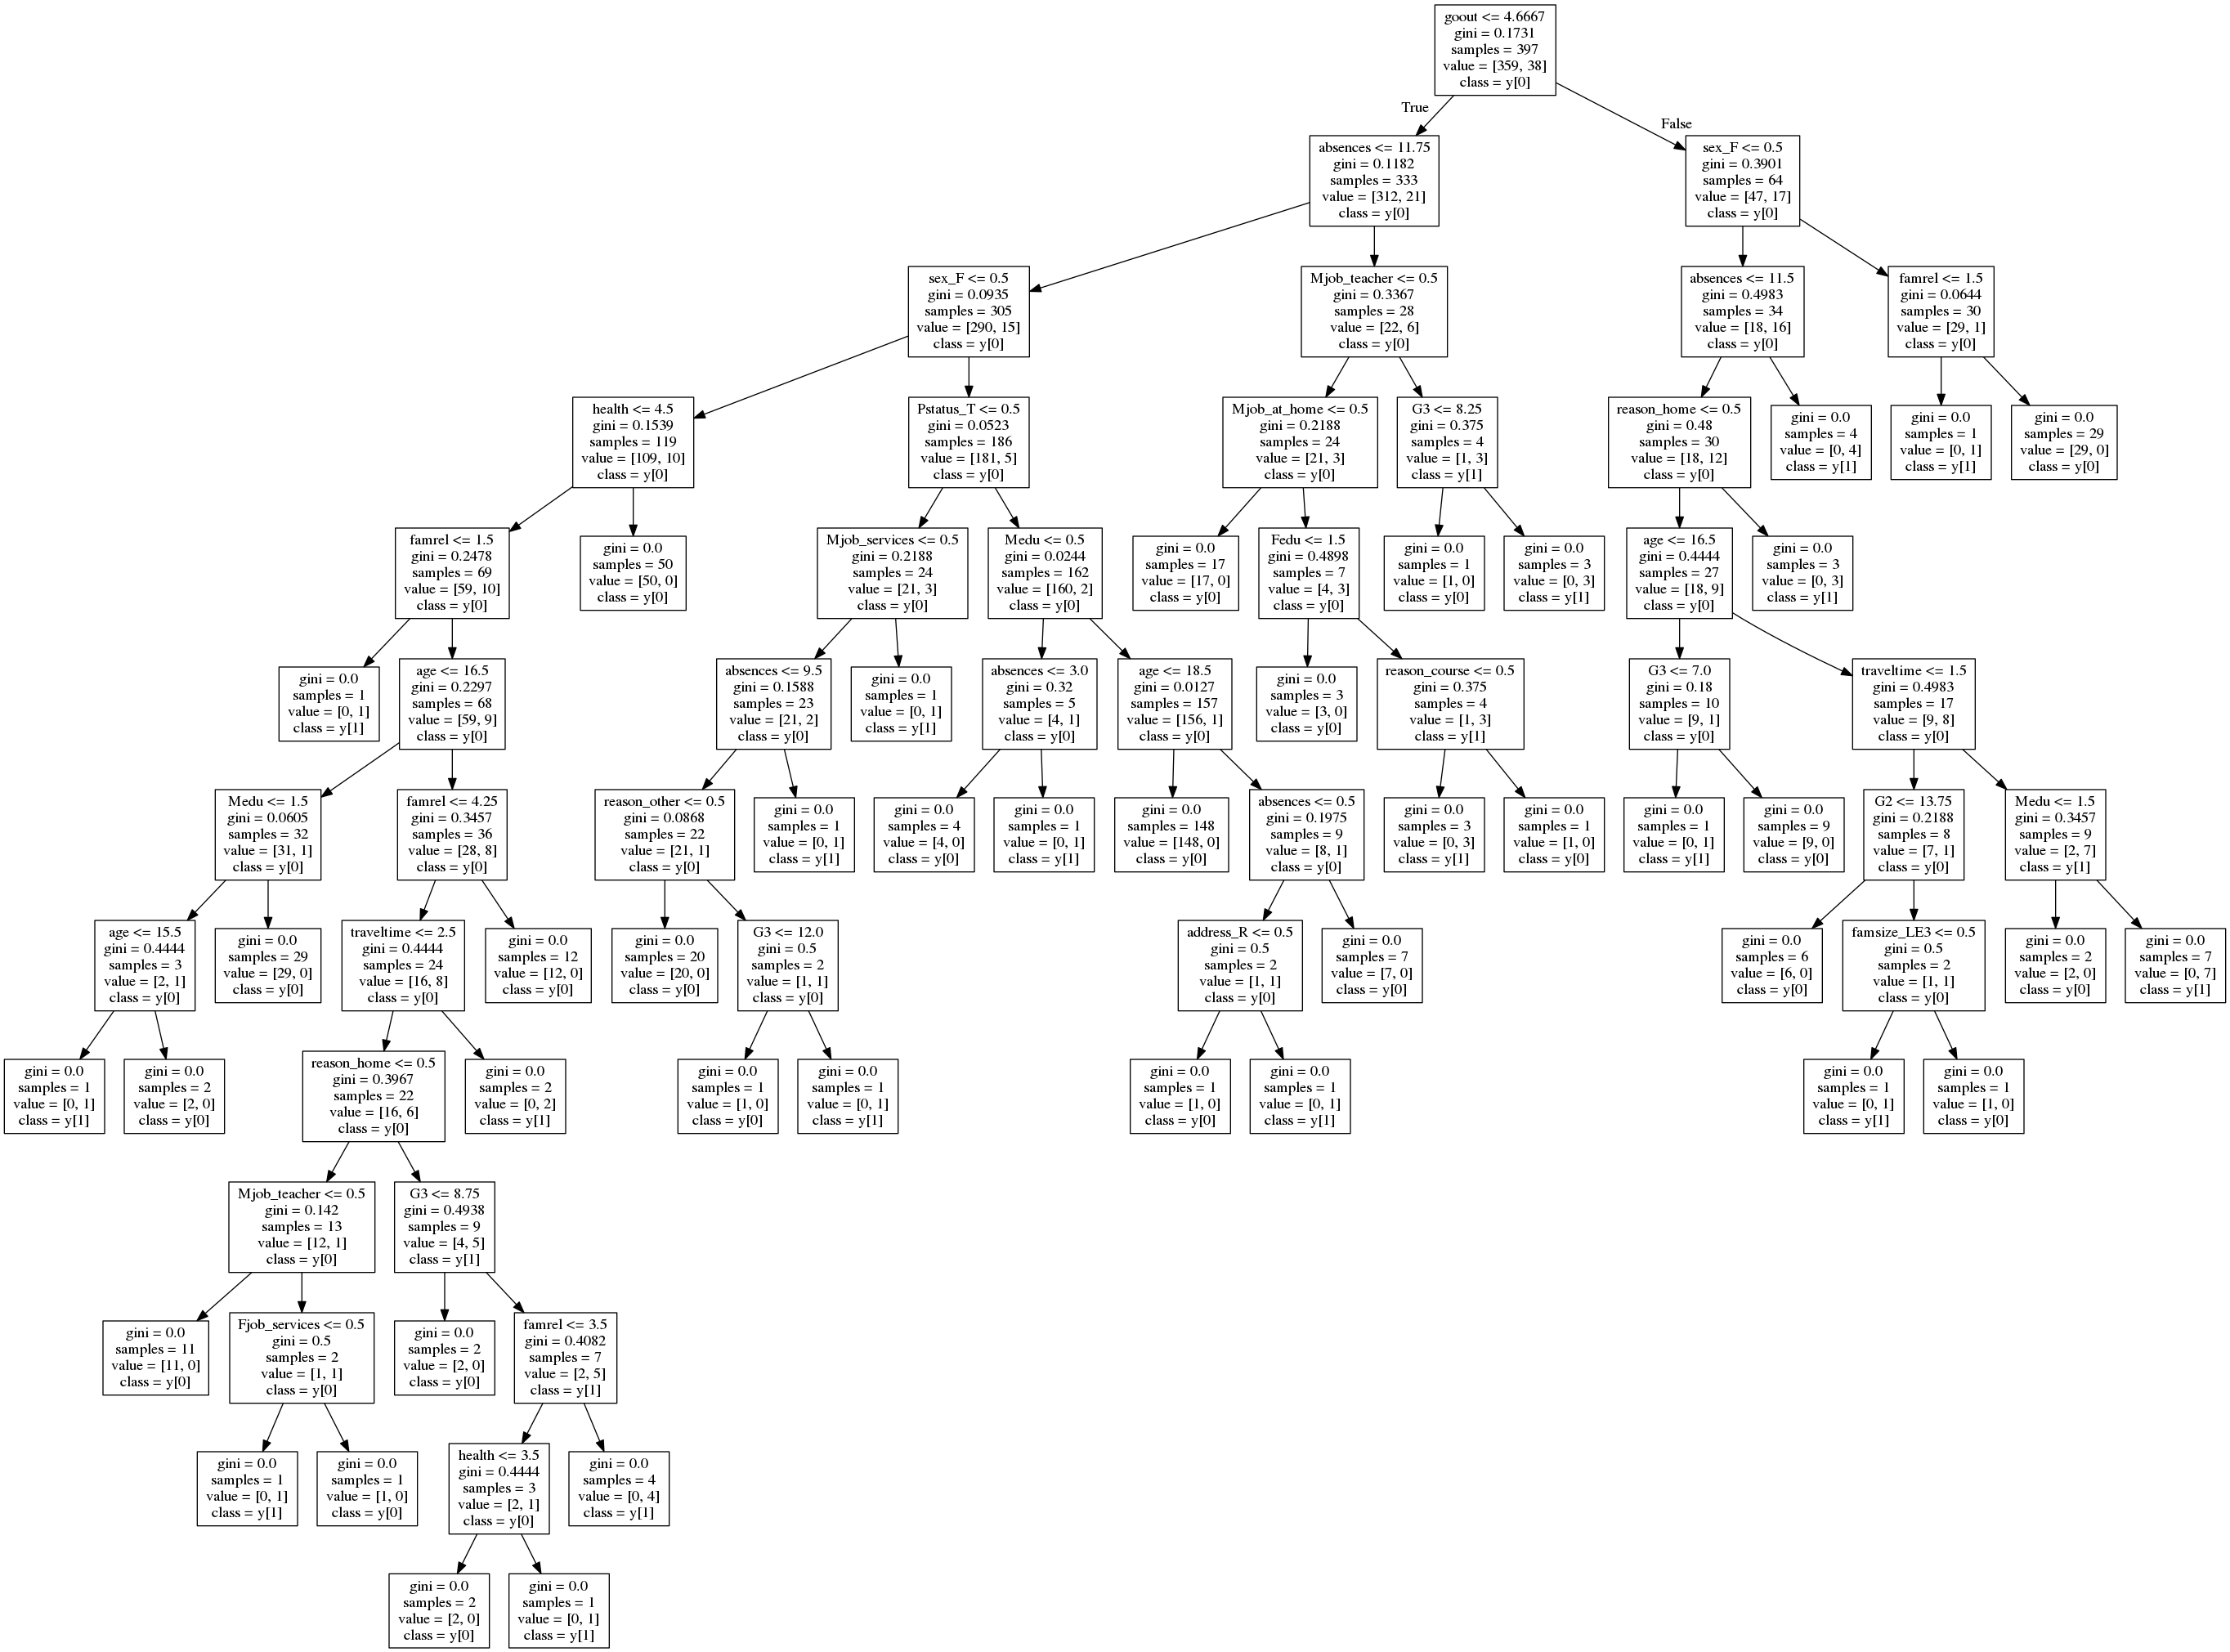

In [11]:
from IPython.display import Image 
import io
import pydot

dot_data = io.StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=data.columns.values,
                        class_names = True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  
